# Analysis of customer outflow

**Target** - Build and train a model that will predict customer outflow. Target metric - **ROC-AUC** not less 0.88

The operator provides two main types of services:

- Stationary telephone communication. It is possible to connect a telephone to several lines at the same time.

- Internet.Connection can be of two types: via the telephone line DSL or fiber optic.

Such services are also available.:

-Internet Security: Antivirus (DeviceProtection) and unlocking unsafe sites (OnlineSecurity);

- Dedicated technical support line (TechSupport);

- cloud file storage for data backup (Onlinebackup);

- StreamingTV StreamingTV and Film Catalog (StreamingMovies).

- Operators want to learn to predict the outflow of customers.If it turns out that the user plans to leave, prompted promotions and special conditions.

Data consists of files obtained from different sources:

- contract.csv - information about the contract;

- Personal.csv - customer personal data;

- internet.csv - information about Internet services;

- Phone.csv - information about telephony services.

All files column Customerid contains the client code.Information about contracts is relevant on February 1, 2020.

## Plan

1. [X] Exploratory Data Analysis
    - [x] Decide what to do with empty values
    - [x] Create a column with a binary targeted feature, depending on the date of the end (its availability?)
    - [x] Neat union of DataFrames into one. 
2. [x] Research Data Analysis
    - [x] Distribution of monthly payments of all customers and those who gone
    - [x] Statistical metrics for all customers, and those who left: middle, min, max, median, quantilica
    - [x] Graphs with shares of customers who use the Internet, telephony and both services
    - [x] graphics with shares of customers who use additional services
3. [x] Prepare data for models
    - [x] Normalization and removal of emissions
    - [x] Research on multicollinarity
    - [x] elimination of minor features
    - [x] coding categorical features
    - [x] Scaling quantitative features
    - [x] Checking on the imbalance of classes and deliverance, if any
4. [x] Learning simple models with automatic parameters.
5. [x] Try a gradient busting (for example, CATBOOST and LIGHTBGM models)
6. [x] Selection, Testing the best model and comparing it with a dummy model
7. [x] Conclusions, Report

## Imports, functions, data reading

In [21]:
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow import keras
 
import warnings
warnings.filterwarnings('ignore')

In [22]:
try: 
    df_contract = pd.read_csv('./data/contract.csv', na_values=' ')
    df_internet = pd.read_csv('./data/internet.csv', na_values=' ')
    df_personal = pd.read_csv('./data/personal.csv', na_values=' ')
    df_phone = pd.read_csv('./data/phone.csv', na_values=' ')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv', na_values=' ')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv', na_values=' ')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv', na_values=' ')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv', na_values=' ')

In [23]:
def quick_description(df):
    df.info()
    print('Number of duplicates:', df.duplicated().sum())
    print('Number of unique users:', len(df['customerID'].unique()))
    print('Oscillation: ', df.isna().sum())

In [24]:
def numeric_feature_distribution(df, column):
      filtered_df=df[column]
      filtered_df_notclient=df[df['Churn'] == 'Yes'][column]
      mean_full = filtered_df.mean()
      mean_notclient =  filtered_df_notclient.mean()
      median_full = filtered_df.median()
      median_notclient =  filtered_df_notclient.median()
      min_full = filtered_df.min()
      min_notclient =  filtered_df_notclient.min()
      max_full = filtered_df.max()
      max_notclient =  filtered_df_notclient.max()
      q1_full = filtered_df.quantile(0.25)
      q3_full = filtered_df.quantile(0.75)
      q1_notclient = filtered_df_notclient.quantile(0.25)
      q3_notclient = filtered_df_notclient.quantile(0.75)
      print ('\033[94m'+column+'\033[0m')
      print('\033[1m'+'All customers:'+'\033[0m')  
      print('Median: {:.0f}'.format(median_full),', The average: {:.0f}'.format(mean_full),
            ', Minimum value: {:.0f}'.format(min_full), ',  Maximum value: {:.0f}'.format(max_full),
            ', 25% quantine: {:.0f}'.format(q1_full), ', 75% quantine: {:.0f}'.format(q3_full))
      print ('\033[1m'+'Weed customers:'+'\033[0m')
      print('Median: {:.0f}'.format(median_notclient),', Среднее: {:.0f}'.format(mean_notclient),
            ', Minimum meaning: {:.0f}'.format(min_notclient), ',  Maximum meaning: {:.0f}'.format(max_notclient),
            ', 25% quantine: {:.0f}'.format(q1_notclient), ', 75% quantine: {:.0f}'.format(q3_notclient))

      ax = df.plot(kind='hist', y=column, ec='black', bins=30, 
                                    linewidth=1, alpha=0.5, label='All customers', color='g')
      filtered_df_notclient.plot(kind='hist', y=column, ec='black', bins=30,linewidth=1, alpha=0.5, 
                              label='Weed customers', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='b')
      ax.set_ylabel('Frequency of values', fontsize=13)
      ax.set_xlabel(column, fontsize=13)
      ax.set_title('Distribution of ' + column, fontsize=17, fontweight='bold')
      plt.show()

In [25]:
def boxplot_distribution(df, column):
    plt.figure(figsize=(15,3))
    sns.boxplot(df[column], color='g').set(xlabel='Values', ylabel=column)                          
    plt.title(label='"Box plot "by ' + column, fontdict={'fontsize': 18})
    plt.show()

In [26]:
def categorial_feature_distribution(df, categories, nrows, ncols, size=15, rotation=0):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size, size * 2))
    for idx, feat in enumerate(categories):
        sns.countplot(df[feat], hue='Churn', data=df, ax=ax[idx // ncols, idx % ncols])
        ax[idx//ncols, idx%ncols].set_xticklabels(ax[idx//ncols, idx%ncols].get_xticklabels(), rotation=rotation)
        ax[idx//ncols, idx%ncols].set_title('Distribution of PA ' + feat)
        ax[idx//ncols, idx%ncols].set_ylabel('Quantity');
        ax[idx//ncols, idx%ncols].title.set_size(16)

In [27]:
def model_learning(model, parameters, train_features, train_target):
    roc_auc_scorer=make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
    grid = GridSearchCV(model, parameters, scoring=roc_auc_scorer, cv=5, n_jobs = -1)
    grid.fit(train_features, train_target)
    print('Best validation assessment: ', grid.best_score_)
    print('Top hyperparameters of the model on validation: ', grid.best_params_)
    print('The best model: ', grid.best_estimator_)
    return grid.best_estimator_

In [28]:
def feature_importance(model, train_features):
    feats = {}
    for feature, importance in zip(train_features.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('features', fontsize=25, weight = 'bold')
    plt.title('The importance of features', fontsize=25, weight = 'bold')
    display(plt.show())
    display(importances)

In [29]:
def test_scoring(model, test_features, test_target, isNeuron=False):
    
    pred_proba_test = model.predict(test_features) if isNeuron else model.predict_proba(test_features)[:, 1]
    pred_test = model.predict(test_features)
    print('Test Metrics:')
    print('Accuracy: ', round(model.score(test_features, test_target), 3))
    print('Presicion: ', round(precision_score(test_target, pred_test), 3))
    print('Recall: ', round(recall_score(test_target, pred_test), 3))
    print('AUC-ROC: ', round(roc_auc_score(test_target, pred_proba_test), 3))
    fpr, tpr, thresholds = roc_curve(test_target, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-curve')
    plt.show()

In [30]:

def upsample(features, target, repeat):
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    features_upsampled=pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled=pd.concat([target_zeros]+[target_ones]*repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,random_state=666)
    return features_upsampled, target_upsampled

In [31]:
def downsample(features, target, fraction):
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=666)]+[features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=666)]+[target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state=666)
    return features_downsampled, target_downsampled

## Data Analysis and Position

### Contracts

In [32]:
display(df_contract)
quick_description(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
Number of duplicates: 0
Number of unique users: 7043
Oscillation:  customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64


Total 7043 users.There are no duplicates.There are 11 empty values in Totalcharges. Immediately examine them

In [33]:
nan_contract_rows = df_contract[df_contract['TotalCharges'].isna()]

display(nan_contract_rows)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [34]:
print('Share of empty values', len(nan_contract_rows)/df_contract.shape[0] * 100 )


Share of empty values 0.1561834445548772


All empty values are for the one date. The share of empty values is infeatureificant. Because "Information on contracts is relevant on February 1, 2020.", This means that the data, apparently, is for the day of unloading the date. They can be removed after the merge of the DataFrames because they have no sense for analytics.

In [35]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')


We will add the target feature of customer outflow - **Churn**. If a date is present in the ENDDATE column, then the client has left (YES), otherwise he is on the network (NO)

In [36]:
df_contract['Churn'] = df_contract['EndDate'].apply(lambda x: x if x == 'No' else 'Yes')
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Let's change type of columns *begindate* and *EndDate* to the date type and fill empty values of EndDate with February 1, 2020 for two reasons:
1) it will be needed to calculate the "lifetime" of the client
2) it does not distort the data, because We have already allocated target feature in *Churn*

In [37]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x), format='%Y-%m-%d')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 495.3+ KB


Add a feature "LIFETIME" - the lifetime of the client from *BeginDate* to *EndDate* in the days

In [38]:
df_contract['Lifetime'] = (df_contract['EndDate'] - df_contract['BeginDate']).astype('timedelta64[D]').astype('int')
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61


### Интернет

In [39]:
display(df_internet)
quick_description(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Number of duplicates: 0
Number of unique users: 5517
Oscillation:  customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


Only 5517 users with the Internet, which is much less than the total number of contracts. Not everyone uses the Internet.

There are no duplicates. No empty values

### Телефон

In [40]:
display(df_phone)
quick_description(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Number of duplicates: 0
Number of unique users: 6361
Oscillation:  customerID       0
MultipleLines    0
dtype: int64


Total 6361 user with phone. Less than the total number of contracts. Not everyone uses the phone.

No empty values,  no duplicates

### Customer Information

In [41]:
display(df_personal)
quick_description(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Number of duplicates: 0
Number of unique users: 7043
Oscillation:  customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [42]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

Information is about all contract users. There are no empty values. There are no duplicates.

### Merge

We combine all the DataFrames, delete customers who just joined and fill the empty values for those who do not use any service using category 'Do not use'

In [43]:
df_full = pd.merge(df_contract, df_personal, on = 'customerID',how= 'left')
df_full = df_full.dropna()

df_full = pd.merge(df_full, df_phone, on = 'customerID',how= 'left')
df_full = pd.merge(df_full, df_internet, on = 'customerID',how= 'left')
# Здесь нет числовых признаков с пропусками, так что можно заменить все
df_full = df_full.fillna('Do not use')
display(df_full.head())
df_full.info()


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,Female,No,Yes,No,Do not use,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,Male,No,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,Male,No,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,Male,No,No,No,Do not use,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,Female,No,No,No,No,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7032 non-null   object        
 9   Lifetime          7032 non-null   int32         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   object        
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
 14  MultipleLines     7032 n

Check whether there are anomalous users who have a contract, but do not use a phone or the Internet

In [44]:
display(df_full[(df_full['MultipleLines'].isna())&(df_full['InternetService'].isna())])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


There are no such users. Take a look at the meanings of categorical features

In [45]:
df_categorial = list(df_full.columns)[3:6]
df_categorial = df_categorial + list(df_full.columns)[11:20]
df_categorial.append('Churn')
df_categorial.append('gender')

for categorial_feature in df_categorial:
    print(categorial_feature, df_full[categorial_feature].unique())


Type ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
MultipleLines ['Do not use' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'Do not use']
OnlineSecurity ['No' 'Yes' 'Do not use']
OnlineBackup ['Yes' 'No' 'Do not use']
DeviceProtection ['No' 'Yes' 'Do not use']
TechSupport ['No' 'Yes' 'Do not use']
Churn ['No' 'Yes']
gender ['Female' 'Male']


There are no anomalies in the categories

### Conclusion

* Checked empty values and duplicates in all DataFrames

* Removed 11 users who did not have TotalCharges due to joining at the day of data unloading 

* Added target feature *Churn* Depending on the existence of the end of the contract

* Dates are given in to the appropriate type

* Everything is merget into the one DataFrame

## Research Data Analysis

Let's look at the distribution of different feature among loyal and departed customers.Let's start with "Lifetime"

Lifetime
All customers:
Median: 883 , The average: 988 , Minimum value: 30 ,  Maximum value: 2191 , 25% quantine: 275 , 75% quantine: 1676
Weed customers:
Median: 304 , Среднее: 547 , Minimum meaning: 30 ,  Maximum meaning: 2191 , 25% quantine: 61 , 75% quantine: 883


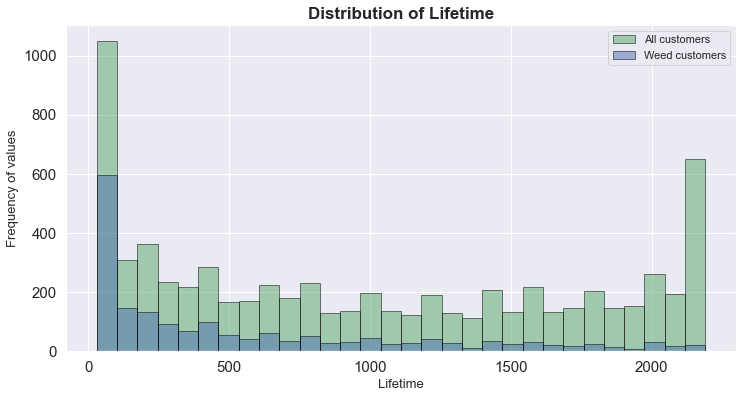

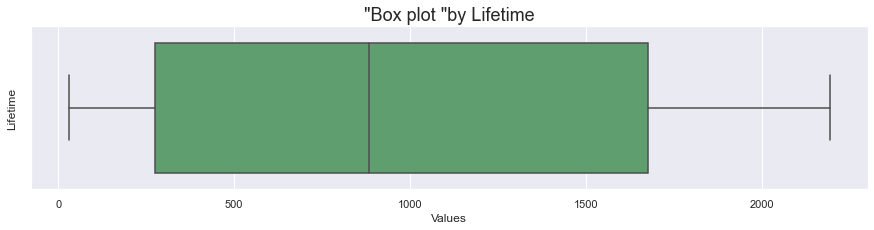

In [46]:
numeric_feature_distribution(df_full, 'Lifetime')
boxplot_distribution(df_full, 'Lifetime')

Bursts are visible at the values of the duration "less than six months" and "longer than three years." Distribution is bimodally. So we have different samples in the one sample and factor, that contributes to this.
Conclusion: most of all new customers leave, What is more than half of all new customers. The remaining conclusions from the network are distributed evenly.

MonthlyCharges
All customers:
Median: 70 , The average: 65 , Minimum value: 18 ,  Maximum value: 119 , 25% quantine: 36 , 75% quantine: 90
Weed customers:
Median: 80 , Среднее: 74 , Minimum meaning: 19 ,  Maximum meaning: 118 , 25% quantine: 56 , 75% quantine: 94


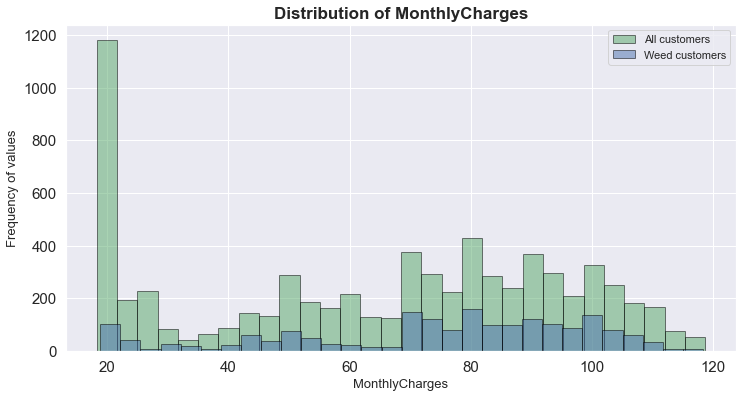

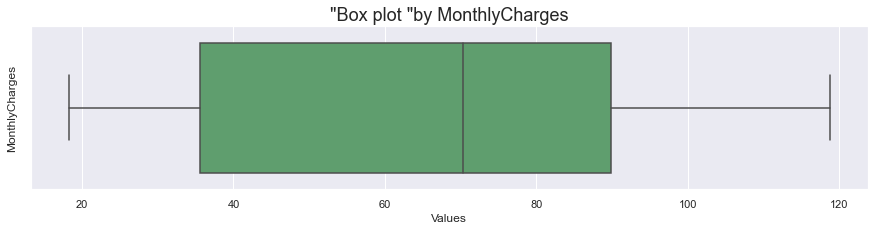

In [47]:
numeric_feature_distribution(df_full, 'MonthlyCharges')
boxplot_distribution(df_full, 'MonthlyCharges')

Visible bursts on values 20 and 80. Distribution bimodal. So we have different samples in the same and factor, that contributes to this.

Most of all clients who leave are Medium + segment, whose Monthly Payment is from 70 to 110 у.е., as well as those who have minimal payment.

TotalCharges
All customers:
Median: 1397 , The average: 2283 , Minimum value: 19 ,  Maximum value: 8685 , 25% quantine: 401 , 75% quantine: 3795
Weed customers:
Median: 704 , Среднее: 1532 , Minimum meaning: 19 ,  Maximum meaning: 8685 , 25% quantine: 134 , 75% quantine: 2331


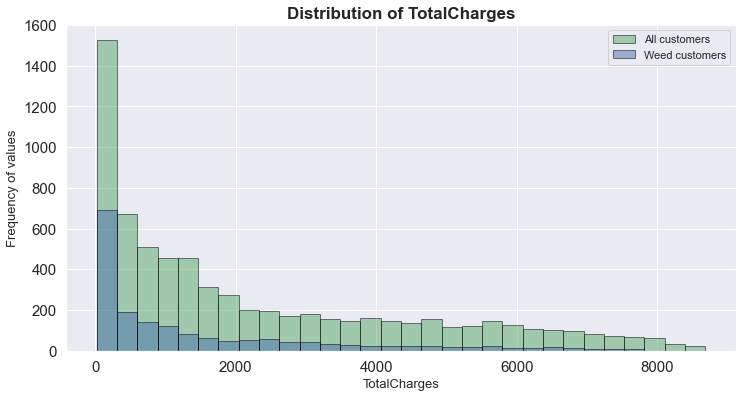

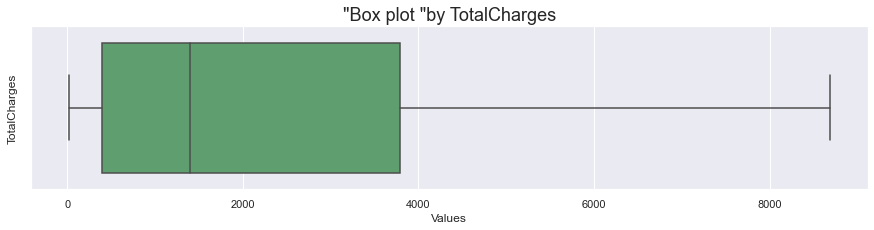

In [48]:
numeric_feature_distribution(df_full, 'TotalCharges')
boxplot_distribution(df_full, 'TotalCharges')

Distribution is normal.
Another confirmation to theory that many customers leave immediately after connecting

### Correlation of quantitative features with loyalty division

,MonthlyCharges,TotalCharges,Lifetime
MonthlyCharges,1.000000,0.651065,0.246715
TotalCharges,0.651065,1.000000,0.825811
Lifetime,0.246715,0.825811,1.000000


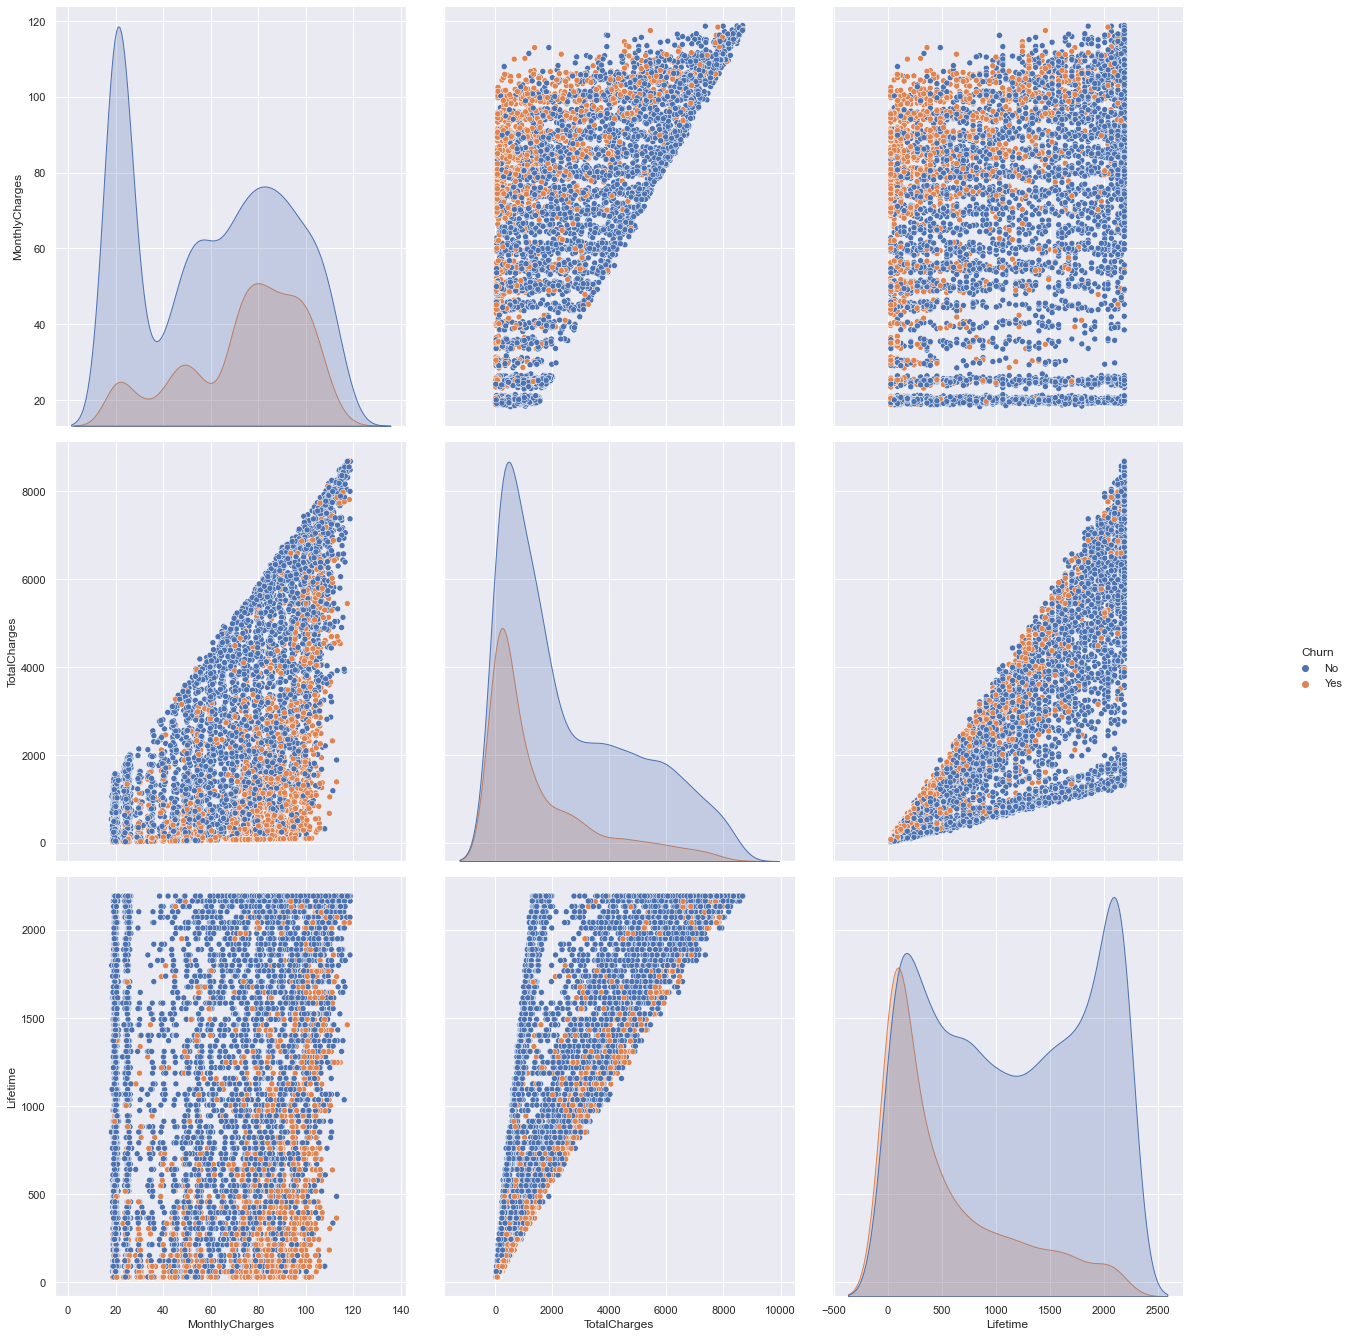

In [49]:
sns.pairplot(df_full, hue='Churn').fig.set_size_inches(20,20)
df_full.corr()


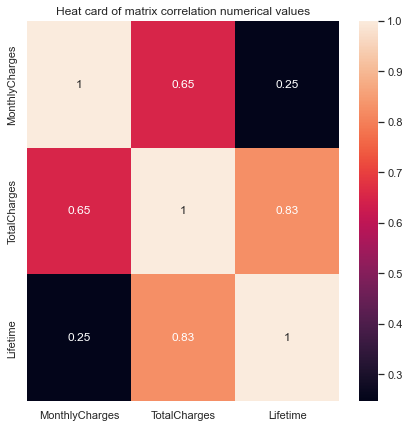

In [50]:
plt.figure(figsize=(7,7))
plt.title('Heat card of matrix correlation numerical values')
sns.heatmap(df_full.corr(), annot=True);

Obviously, some features are quite correlated among themselves.:

- *Lifetime* and *Total Charges* have linear dependency 

- *Total Charges* and *Monthly Charges*

Conclusion 

It makes sense later to get rid of the old feature Totalcharges, and leave Lifetime and Monhlychangers

### Categorical features with loyalty division

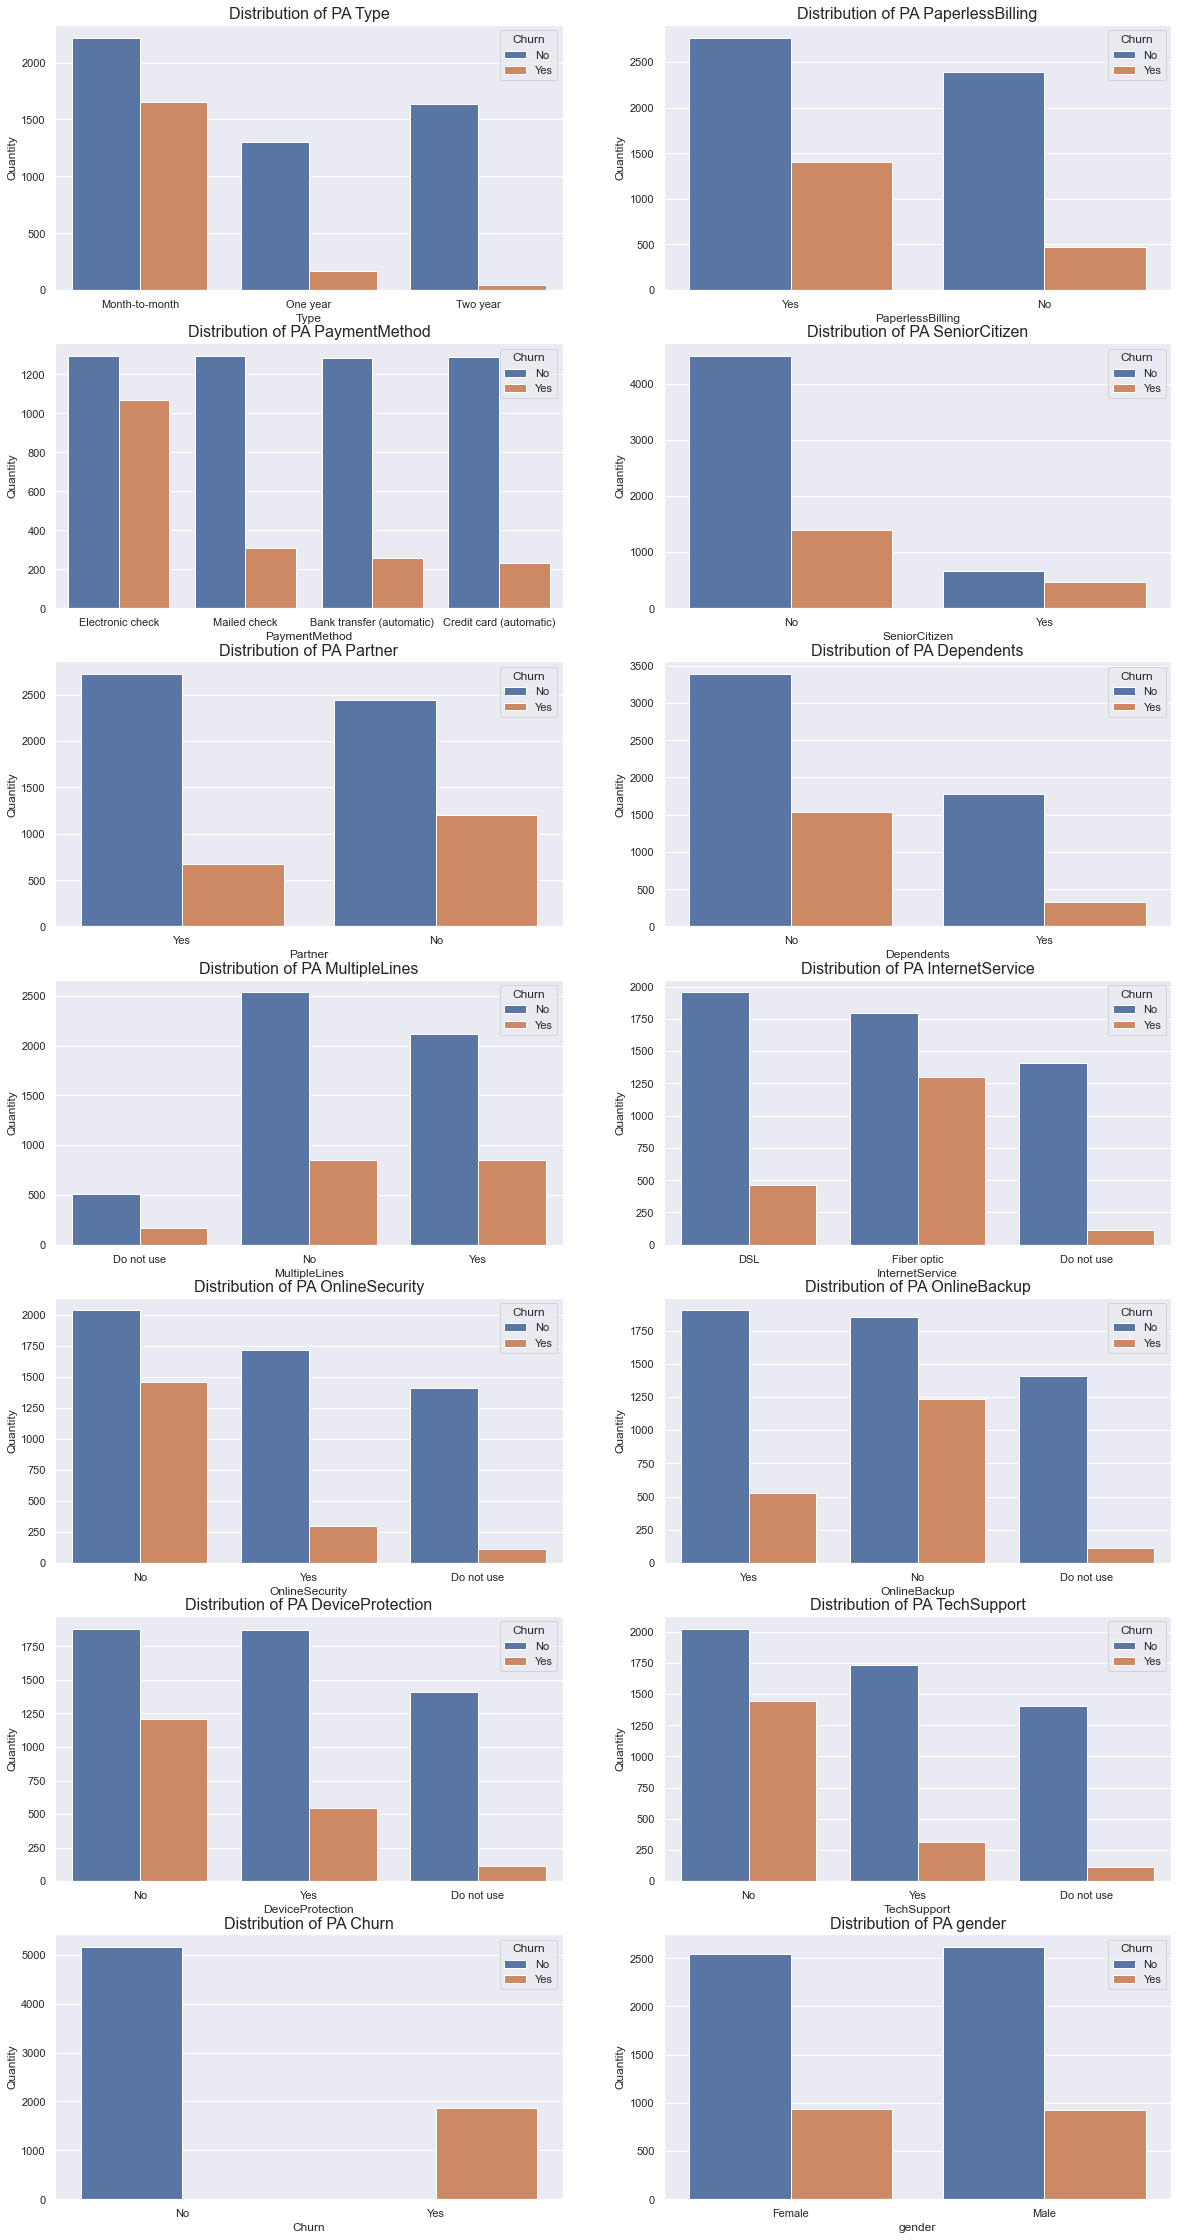

In [51]:
categorial_feature_distribution(df_full, df_categorial, nrows=7, ncols=2, size=20)

Сonclusions: 

* those who pay monthly leave more often  
* those who use *Electronic Check* и *Paperless Billing* leave more often . Perhaps with a certain online payment system have problems
* Use of additional services *Device Protection*, *Online Security*, *Online Backup*, *Fiber Optic*, *Tech Support* obviously not enough to motivate the client to stay
* Senior citizen leave more often by obvious uncontrolled reasons (lack of money, health problems, death)
* Lonely people leave more often, perhaps because of uncontrolled reasons (Moving to the another city withot cell coverage, and so on) 

### Part of online users among all customers and among those who have gone

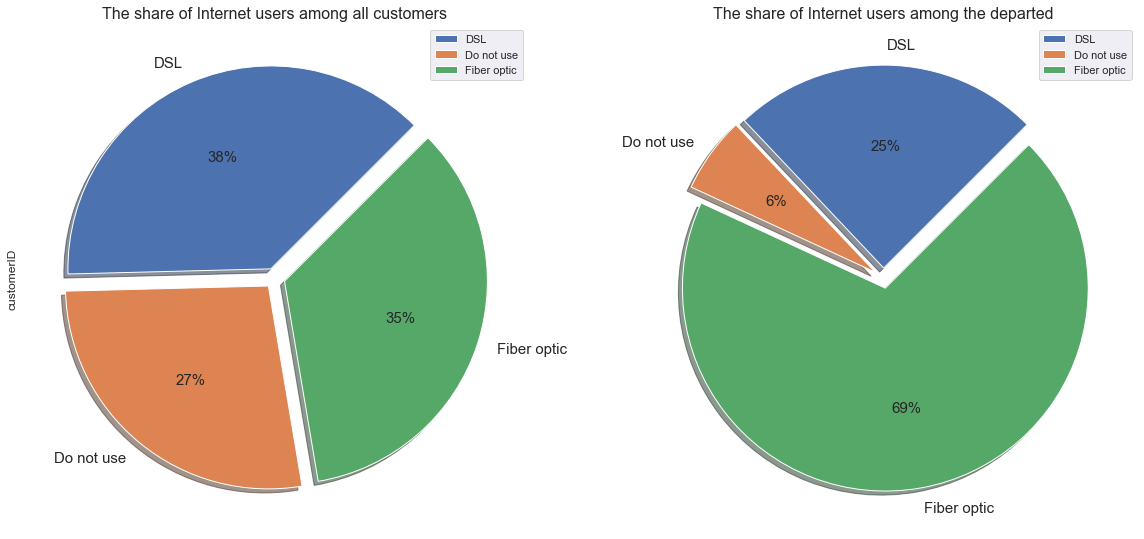

In [52]:
internet_pivot = df_full[df_full['Churn'] == 'No'].pivot_table(index='InternetService', values='customerID', 
                aggfunc = 'count')
internet_churn_pivot = df_full[df_full['Churn'] == 'Yes'].pivot_table(index='InternetService', values='customerID', 
                aggfunc = 'count')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
internet_pivot.plot(ax=ax1, kind='pie',shadow=True, subplots=True, fontsize=15,figsize=(6,6), startangle=45,autopct=lambda p: '{:.0f}%'.format(p), explode = (0.05, 0.05, 0.05))
ax1.set_title('The share of Internet users among all customers')
ax1.title.set_size(16)

internet_churn_pivot.plot(ax=ax2, kind='pie',shadow=True, subplots=True, fontsize=15,figsize=(6,6), startangle=45,autopct=lambda p: '{:.0f}%'.format(p), explode = (0.05, 0.05, 0.05))
ax2.set_title('The share of Internet users among the departed')
ax2.title.set_size(16)

plt.legend(loc=1)
plt.axis('off')
plt.show()

Conclusion: Among the departed customers is a large proportion of Fiber Optic users. There is a chance that they were not satisfied with its quality.

### The share of phone users  among all client and among those who have left

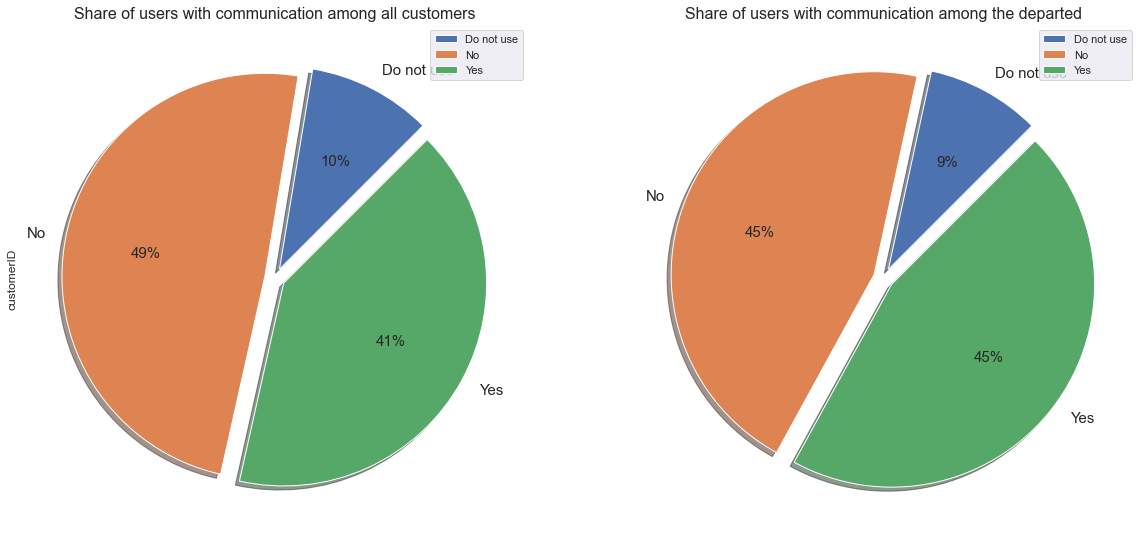

In [53]:
internet_pivot = df_full[df_full['Churn'] == 'No'].pivot_table(index='MultipleLines', values='customerID', 
                aggfunc = 'count')
internet_churn_pivot = df_full[df_full['Churn'] == 'Yes'].pivot_table(index='MultipleLines', values='customerID', 
                aggfunc = 'count')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
internet_pivot.plot(ax=ax1, kind='pie',shadow=True, subplots=True, fontsize=15,figsize=(6,6), startangle=45,autopct=lambda p: '{:.0f}%'.format(p), explode = (0.05, 0.05, 0.05))
ax1.set_title('Share of users with communication among all customers')
ax1.title.set_size(16)

internet_churn_pivot.plot(ax=ax2, kind='pie',shadow=True, subplots=True, fontsize=15,figsize=(6,6), startangle=45,autopct=lambda p: '{:.0f}%'.format(p), explode = (0.05, 0.05, 0.05))
ax2.set_title('Share of users with communication among the departed')
ax2.title.set_size(16)

plt.legend(loc=1)
plt.axis('off')
plt.show()

Conclusion: here the shares for the departed and loyal users are almost the same

### Consclusion

Possible hypotheses for consideration:

* A lot of new clients leave, which is more than a half of all clients. The remaining exits from the network are distributed normally.

* *Lifetime* and *Total Charges* Linearly dependent

* *Total Charges* and *Monthly Charges* have stron correlation

* those who pay monthly leave more often  

* those who use *Electronic Check* и *Paperless Billing* leave more often . Perhaps with a certain online payment system have problems

* Use of additional services *Device Protection*, *Online Security*, *Online Backup*, *Fiber Optic*, *Tech Support* obviously not enough to motivate the client to stay

* Senior citizen leave more often by obvious uncontrolled reasons (lack of money, health problems, death)

* Lonely people leave more often, perhaps because of uncontrolled reasons (Moving to the another city withot cell coverage, and so on) 

* Among the departed customers is a large proportion of Fiber Optic users. There is a chance that they were not satisfied with its quality.

## Preparation of data for models

### Removal of unnecessary features

Extra features:

* *TotalCharges* and *Lifetime*, hanve linear dependency. Let's remove *TotalAmount*, because for financial mitriding we have *MonthlyCharges*

* *customerID*, *BeginDate*, *EndDate* are useless for this model because we have *Lifetime*

In [54]:
df_full = df_full.drop(['TotalCharges', 'customerID', 'BeginDate', 'EndDate'], axis=1)

### Coding categorical features

Encode categorical features by the method One Hot Encoding
Binary features will not change, and features with 2+ categories will be deprived of a case interpretation of modes as numerical.

In [55]:
categorial = df_full.select_dtypes(include='object').columns
df_full_ohe = pd.get_dummies(df_full,drop_first=True,columns=categorial)
display(df_full_ohe.head())

,MonthlyCharges,Lifetime,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_Do not use,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,29.85,31,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0
1,56.95,1036,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0,1,0
2,53.85,61,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0
3,42.30,1371,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0
4,70.70,61,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0


### Normalization of numerical features

In [56]:
numeric=['MonthlyCharges', 'Lifetime']
scaler=StandardScaler()

### Separation to the samples

In [57]:
target_ohe = df_full_ohe['Churn_Yes']
features_ohe = df_full_ohe.drop(['Churn_Yes'], axis=1)  
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
        features_ohe,target_ohe,stratify=target_ohe, test_size=0.25, random_state=666)
print('Training sample: ', features_train_ohe.shape,  target_train_ohe.shape)
print('Test sample: ', features_test_ohe.shape,  target_test_ohe.shape)

Training sample:  (5274, 28) (5274,)
Test sample:  (1758, 28) (1758,)


In [58]:
scaler.fit((features_train_ohe[numeric]))
features_train_ohe[numeric]=scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric]=scaler.transform(features_test_ohe[numeric])

0    0.734215
1    0.265785
Name: Churn_Yes, dtype: float64


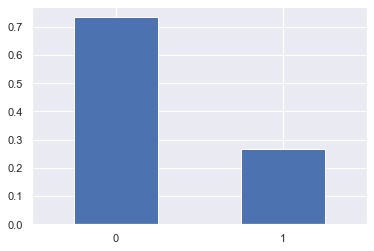

In [59]:
class_frequency=target_ohe.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

The imbalance of the target feature is  3:1
Let's try to fight the built-in balance of models, and using upsampling and downsampling

In [60]:
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train_ohe, 3)
features_downsampled, target_downsampled = downsample(features_train_ohe, target_train_ohe, 0.35)

### Conclusion

Covered
- [x] Normalization and removal of emissions
- [x] Research on multicollinarity
- [x] elimination of minor features
- [x] coding categorical features
- [x] Scaling quantitative features
- [x] Check on the imbalance of classes and proposed methods of getting rid of it

## Training models

We train the logistics regression models, Desigion Tree models and random forest models using three types of samples - ordinary, upsampled and downsampled
Withdraw the metrics for each and compare. For the best model, we will build a graph of the importance of features.

### Logistic Regression

=== Balanced === :
Best validation assessment:  0.8406395164373197
Top hyperparameters of the model on validation:  {'C': 10, 'class_weight': None}
The best model:  LogisticRegression(C=10, n_jobs=-1, random_state=666)
Test Metrics:
Accuracy:  0.809
Presicion:  0.665
Recall:  0.565
AUC-ROC:  0.85


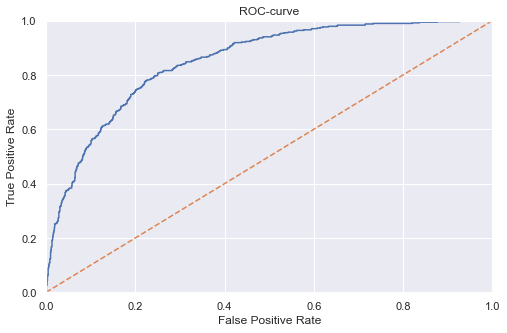

=== Upsampled: === 
Best validation assessment:  0.8422898213936199
Top hyperparameters of the model on validation:  {'C': 20}
The best model:  LogisticRegression(C=20, n_jobs=-1, random_state=666)
Test Metrics:
Accuracy:  0.746
Presicion:  0.514
Recall:  0.824
AUC-ROC:  0.849


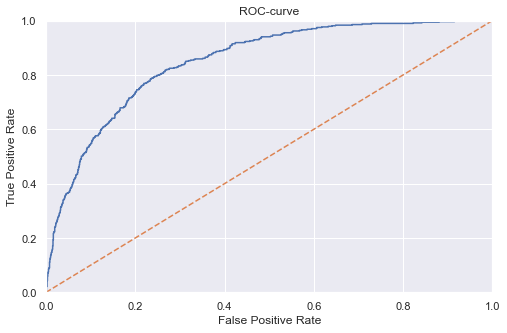

=== Downsampled: ===
Best validation assessment:  0.8427566751773263
Top hyperparameters of the model on validation:  {'C': 5}
The best model:  LogisticRegression(C=5, n_jobs=-1, random_state=666)
Test Metrics:
Accuracy:  0.753
Presicion:  0.522
Recall:  0.822
AUC-ROC:  0.847


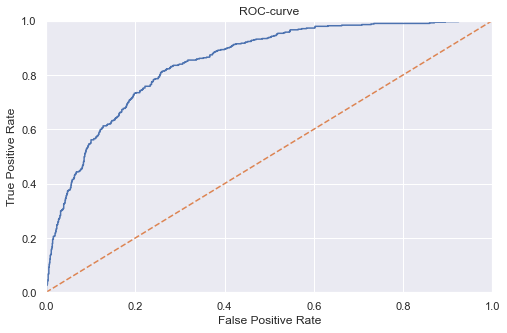

Wall time: 8.23 s


In [61]:
%%time
lr = LogisticRegression(random_state=666, n_jobs=-1)
regress_params_balanced={'class_weight':['balanced',None], 'C':[2, 5, 10, 20]}
regress_params={'C':[2, 5, 10, 20]}

print('=== Balanced === :')
lr_fitted = model_learning(lr, regress_params_balanced ,features_train_ohe, target_train_ohe)
test_scoring(lr_fitted, features_test_ohe, target_test_ohe)

print('=== Upsampled: === ')

lr_fitted_upsampled = model_learning(lr, regress_params ,features_upsampled, target_upsampled)
test_scoring(lr_fitted_upsampled, features_test_ohe, target_test_ohe)

print('=== Downsampled: ===')
lr_fitted_downsampled = model_learning(lr, regress_params ,features_downsampled, target_downsampled)
test_scoring(lr_fitted_downsampled, features_test_ohe, target_test_ohe)

### Decision Tree

=== Balanced === :
Best validation assessment:  0.8419477737719466
Top hyperparameters of the model on validation:  {'class_weight': None, 'max_depth': 6}
The best model:  DecisionTreeClassifier(max_depth=6, random_state=666)
Test Metrics:
Accuracy:  0.815
Presicion:  0.741
Recall:  0.465
AUC-ROC:  0.844


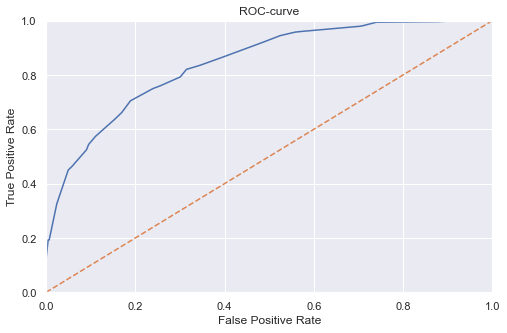

=== Upsampled: === 
Best validation assessment:  0.8957335703091914
Top hyperparameters of the model on validation:  {'max_depth': 16}
The best model:  DecisionTreeClassifier(max_depth=16, random_state=666)
Test Metrics:
Accuracy:  0.767
Presicion:  0.557
Recall:  0.595
AUC-ROC:  0.724


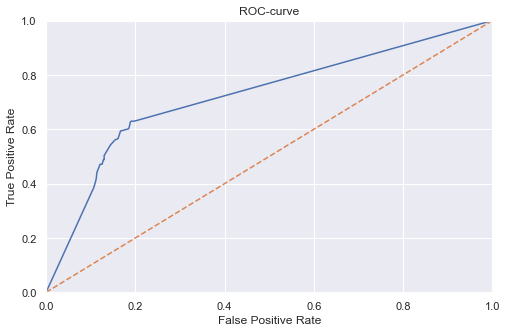

=== Downsampled: ===
Best validation assessment:  0.8343441039138403
Top hyperparameters of the model on validation:  {'max_depth': 6}
The best model:  DecisionTreeClassifier(max_depth=6, random_state=666)
Test Metrics:
Accuracy:  0.726
Presicion:  0.49
Recall:  0.76
AUC-ROC:  0.826


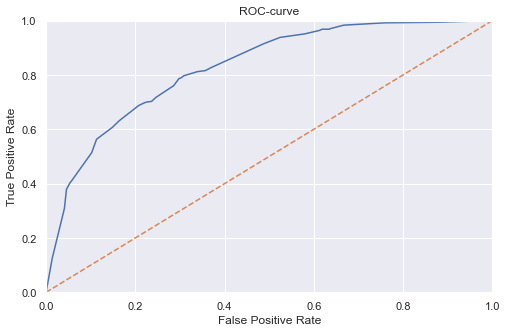

Wall time: 1.12 s


In [62]:
%%time
tree= DecisionTreeClassifier(random_state=666)

tree_params_balanced = {'max_depth': range(1, 17, 5),'class_weight':['balanced',None]}
tree_params = {'max_depth': range(1, 17, 5)}

print('=== Balanced === :')
tree_fitted = model_learning(tree, tree_params_balanced ,features_train_ohe, target_train_ohe)
test_scoring(tree_fitted, features_test_ohe, target_test_ohe)

print('=== Upsampled: === ')

tree_fitted_upsampled = model_learning(tree, tree_params ,features_upsampled, target_upsampled)
test_scoring(tree_fitted_upsampled, features_test_ohe, target_test_ohe)

print('=== Downsampled: ===')
tree_fitted_downsampled = model_learning(tree, tree_params ,features_downsampled, target_downsampled)
test_scoring(tree_fitted_downsampled, features_test_ohe, target_test_ohe)

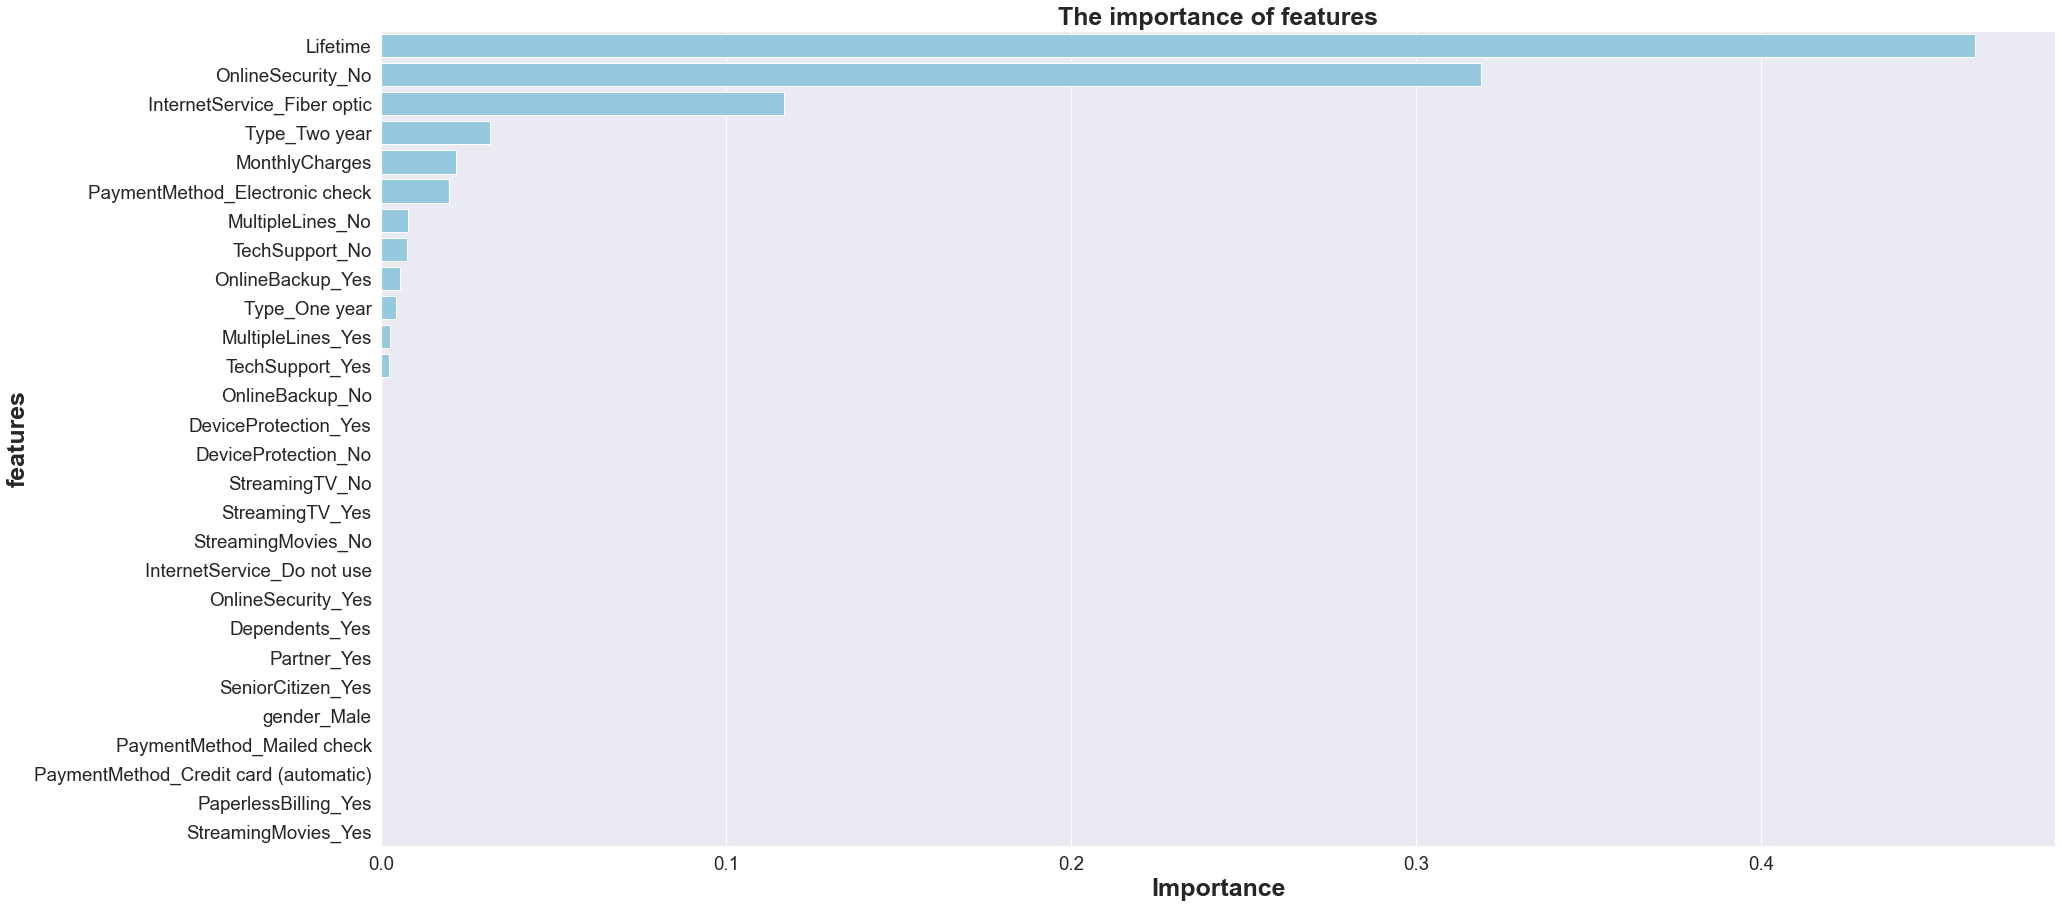

None

,Features,Gini-Importance
0,Lifetime,0.462056
1,OnlineSecurity_No,0.318677
2,InternetService_Fiber optic,0.116740
3,Type_Two year,0.031676
4,MonthlyCharges,0.021612
5,PaymentMethod_Electronic check,0.019506
6,MultipleLines_No,0.007762
7,TechSupport_No,0.007583
8,OnlineBackup_Yes,0.005332
9,Type_One year,0.004338


In [63]:
feature_importance(tree_fitted, features_downsampled)

### Random Forest

=== Balanced === :
Best validation assessment:  0.852384330403055
Top hyperparameters of the model on validation:  {'class_weight': None, 'max_depth': 7, 'n_estimators': 16}
The best model:  RandomForestClassifier(max_depth=7, n_estimators=16, n_jobs=-1,
                       random_state=666)
Test Metrics:
Accuracy:  0.819
Presicion:  0.703
Recall:  0.548
AUC-ROC:  0.847


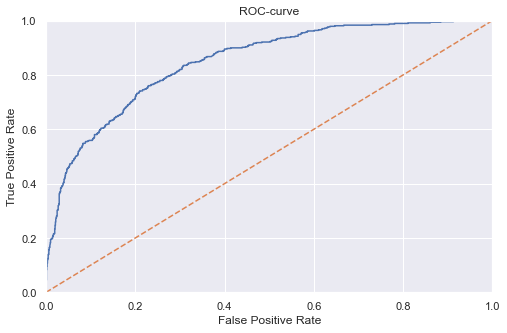

=== Upsampled === :
Best validation assessment:  0.9010000441065357
Top hyperparameters of the model on validation:  {'max_depth': 9, 'n_estimators': 16}
The best model:  RandomForestClassifier(max_depth=9, n_estimators=16, n_jobs=-1,
                       random_state=666)
Test Metrics:
Accuracy:  0.752
Presicion:  0.522
Recall:  0.773
AUC-ROC:  0.841


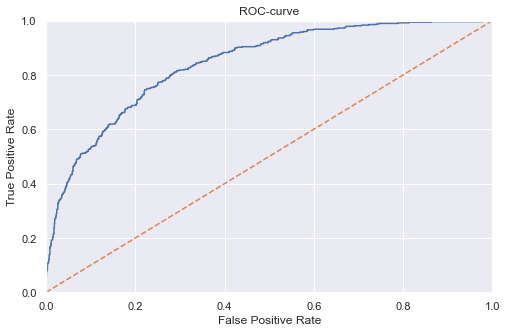

=== Downsampled === :
Best validation assessment:  0.8433650763426801
Top hyperparameters of the model on validation:  {'max_depth': 7, 'n_estimators': 16}
The best model:  RandomForestClassifier(max_depth=7, n_estimators=16, n_jobs=-1,
                       random_state=666)
Test Metrics:
Accuracy:  0.739
Presicion:  0.505
Recall:  0.801
AUC-ROC:  0.845


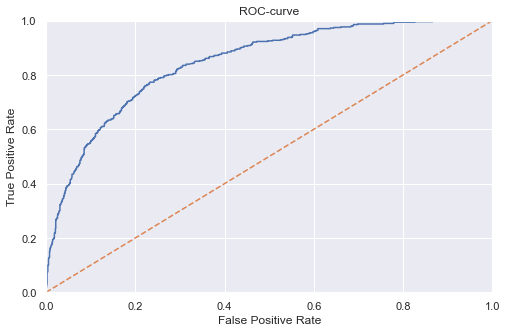

Wall time: 5.78 s


In [64]:
%%time
rf = RandomForestClassifier(random_state=666, n_jobs=-1)
rf_param_balanced = {'max_depth': range(1, 10, 2), 'n_estimators':range(1,21,5), 'class_weight':['balanced',None]}

rf_param = {'max_depth': range(1, 10, 2), 'n_estimators':range(1,21,5)}

print('=== Balanced === :')
rf_fitted = model_learning(rf, rf_param_balanced, features_train_ohe, target_train_ohe)
test_scoring(rf_fitted, features_test_ohe, target_test_ohe)

print('=== Upsampled === :')
rf_fitted_upsampled = model_learning(rf, rf_param, features_upsampled, target_upsampled)
test_scoring(rf_fitted_upsampled, features_test_ohe, target_test_ohe)

print('=== Downsampled === :')
rf_fitted_downsampled = model_learning(rf, rf_param, features_downsampled, target_downsampled)
test_scoring(rf_fitted_downsampled, features_test_ohe, target_test_ohe)

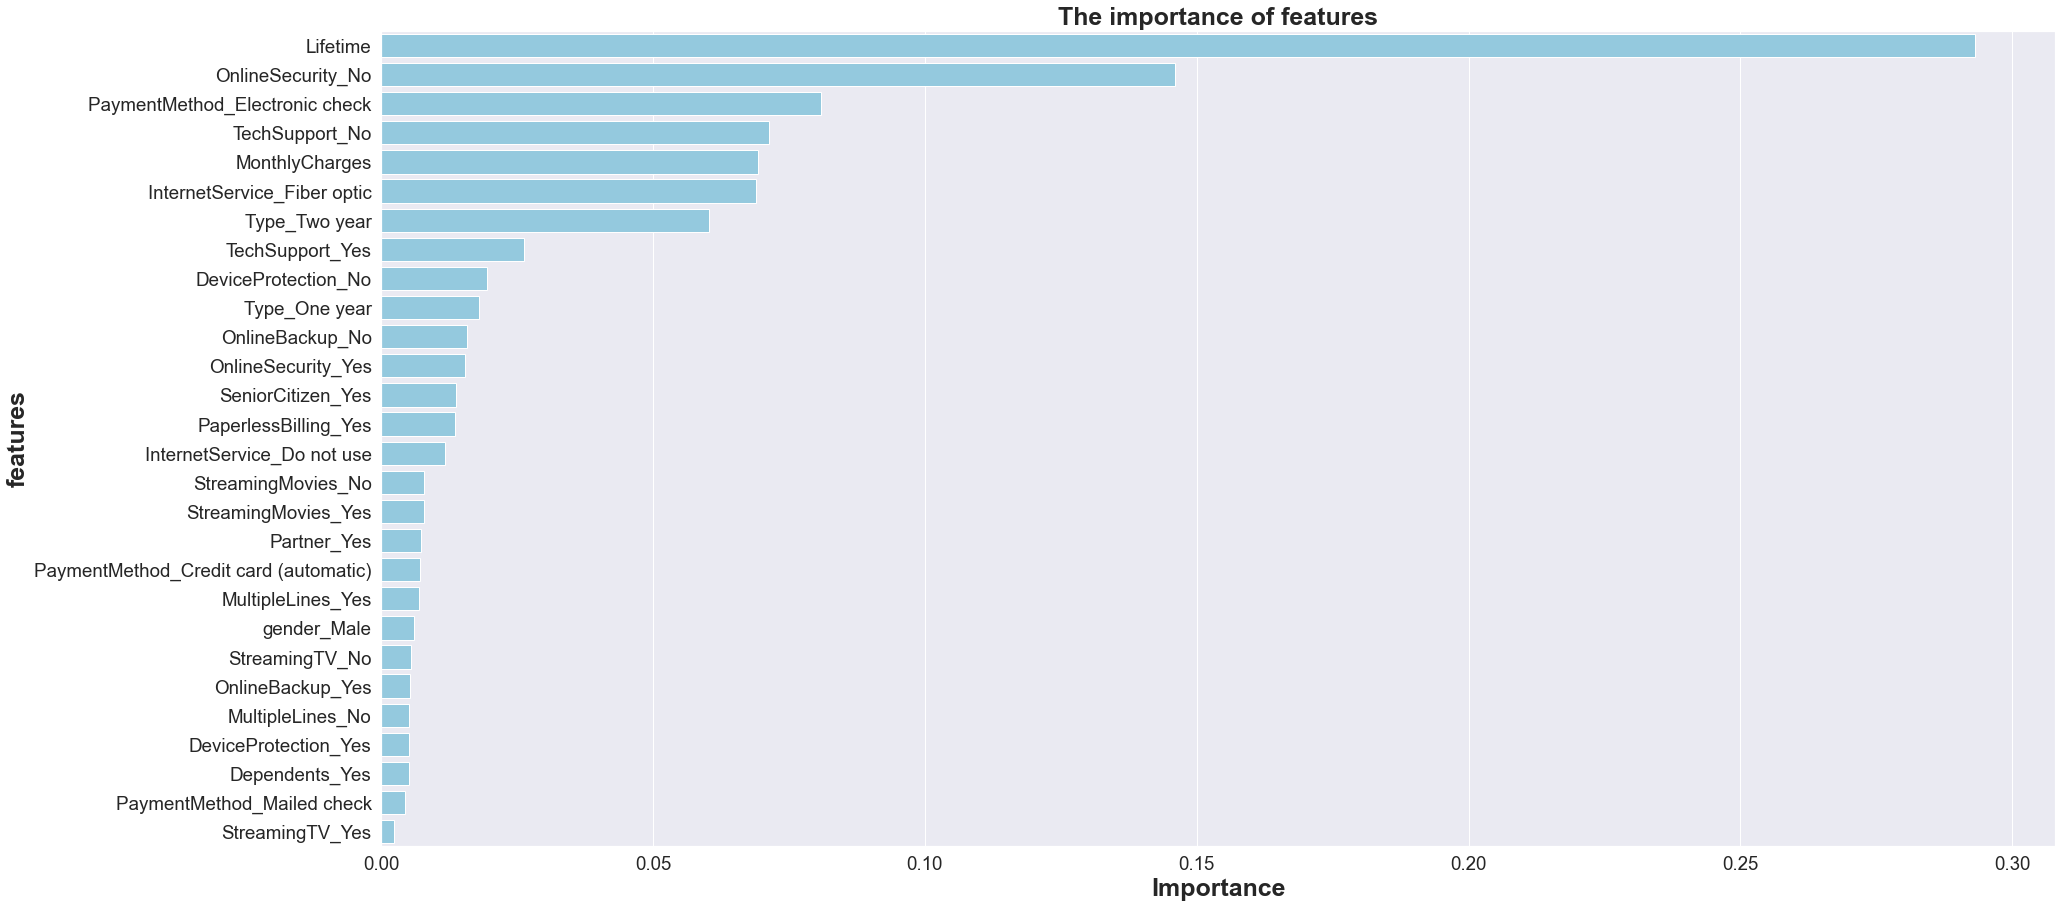

None

,Features,Gini-Importance
0,Lifetime,0.293241
1,OnlineSecurity_No,0.146042
2,PaymentMethod_Electronic check,0.080877
3,TechSupport_No,0.071346
4,MonthlyCharges,0.069260
5,InternetService_Fiber optic,0.068969
6,Type_Two year,0.060318
7,TechSupport_Yes,0.026348
8,DeviceProtection_No,0.019430
9,Type_One year,0.017932


In [65]:
feature_importance(rf_fitted, features_train_ohe)

### Сравнение простых моделей

In [66]:
data_line = {'Model':['Linear regression' ,'Decision Tree',  'Random Forest'],         
        'ROC-AUC ordinal': [0.84, 0.841,  0.852],
        'ROC-AUC upsample x3': [0.84, 0.895,  0.901],
       'ROC-AUC downsample x0.35': [0.84,0.834, 0.843]}
data_pivot = pd.DataFrame.from_dict(data_line)
print('On training data')
display(data_pivot)

On training data


,Model,ROC-AUC ordinal,ROC-AUC upsample x3,ROC-AUC downsample x0.35
0,Linear regression,0.840,0.840,0.840
1,Decision Tree,0.841,0.895,0.834
2,Random Forest,0.852,0.901,0.843


In [67]:
data_line = {'Model':['Linear regression' ,'Decision Tree',  'Random Forest'],         
        'ROC-AUC ordinal': [0.85, 0.661,  0.848],
        'ROC-AUC upsample x3': [0.849, 0.661,  0.841],
       'ROC-AUC downsample x0.35': [0.847,0.78, 0.845]}
data_pivot = pd.DataFrame.from_dict(data_line)
print('On test data')
display(data_pivot)

On test data


,Model,ROC-AUC ordinal,ROC-AUC upsample x3,ROC-AUC downsample x0.35
0,Linear regression,0.850,0.849,0.847
1,Decision Tree,0.661,0.661,0.780
2,Random Forest,0.848,0.841,0.845


Conclusion:
In training data among simple models, the Random Forest model, educated on upsampled data, leads although metrics on test data say that the model is slightly over-trained

### LbGm

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
Best validation assessment:  0.9057073279716302
Top hyperparameters of the model on validation:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
The best model:  LGBMClassifier(l2_leaf_reg=1, max_depth=5, n_estimators=500, random_state=666)
Test Metrics:
Accuracy:  0.858
Presicion:  0.79
Recall:  0.636
AUC-ROC:  0.907


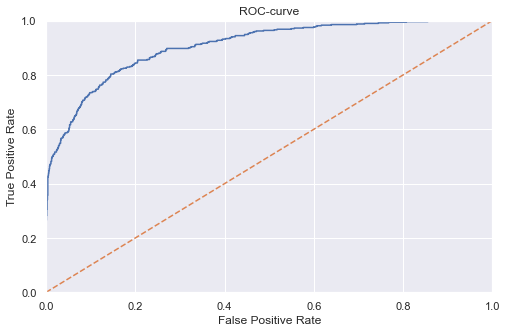

Wall time: 23.3 s


In [68]:
%%time
lgbm= LGBMClassifier(n_jobs=-1, random_state=666)
lgbm_param = {'n_estimators': [300, 500, 1000],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 5, 9],
                  'l2_leaf_reg': [1, 3]}
    
lgbm_fitted = model_learning(lgbm, lgbm_param, features_train_ohe, target_train_ohe)
test_scoring(lgbm_fitted, features_test_ohe, target_test_ohe)

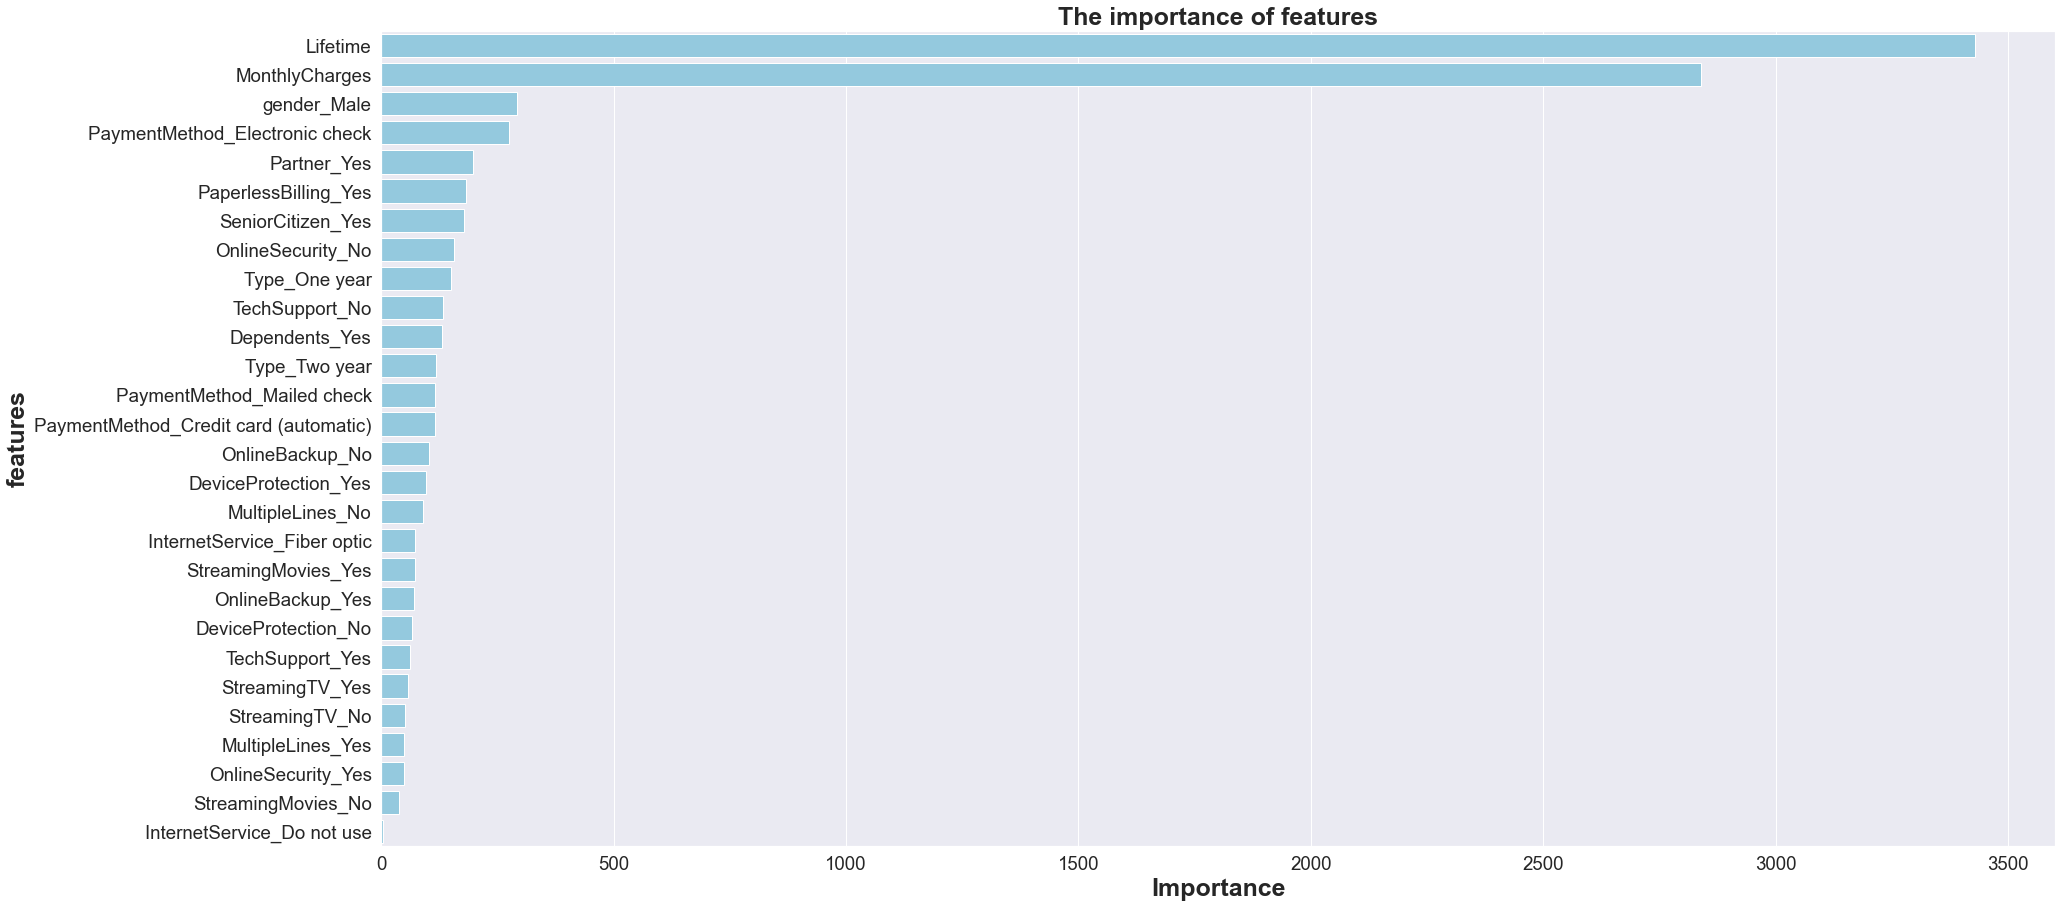

None

,Features,Gini-Importance
0,Lifetime,3430
1,MonthlyCharges,2839
2,gender_Male,293
3,PaymentMethod_Electronic check,275
4,Partner_Yes,197
5,PaperlessBilling_Yes,183
6,SeniorCitizen_Yes,179
7,OnlineSecurity_No,157
8,Type_One year,151
9,TechSupport_No,134


In [69]:
feature_importance(lgbm_fitted, features_test_ohe)

### CatBoost

In [70]:
target = df_full['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
features = df_full.drop(['Churn'], axis=1)  



features_train, features_test, target_train, target_test = train_test_split(
        features,target,stratify=target, test_size=0.25, random_state=666)

scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (5274, 17) (5274,)
Тестовая выборка:  (1758, 17) (1758,)


In [71]:
# %%time
cat_features=['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
catboost = CatBoostClassifier(random_state=666, cat_features=cat_features, iterations=200, loss_function="Logloss")
catboost_param = params={'depth': range(5, 10, 15), 'learning_rate': [0.5, 0.8, 1.0]}



catboost_fitted = model_learning(catboost, catboost_param, features_train, target_train)


0:	learn: 0.4852246	total: 210ms	remaining: 41.8s
1:	learn: 0.4246033	total: 245ms	remaining: 24.3s
2:	learn: 0.4096160	total: 281ms	remaining: 18.4s
3:	learn: 0.3960707	total: 328ms	remaining: 16.1s
4:	learn: 0.3904576	total: 360ms	remaining: 14s
5:	learn: 0.3844976	total: 391ms	remaining: 12.6s
6:	learn: 0.3834927	total: 424ms	remaining: 11.7s
7:	learn: 0.3808325	total: 476ms	remaining: 11.4s
8:	learn: 0.3784794	total: 532ms	remaining: 11.3s
9:	learn: 0.3783752	total: 561ms	remaining: 10.7s
10:	learn: 0.3776921	total: 598ms	remaining: 10.3s
11:	learn: 0.3749746	total: 647ms	remaining: 10.1s
12:	learn: 0.3659890	total: 701ms	remaining: 10.1s
13:	learn: 0.3645415	total: 737ms	remaining: 9.79s
14:	learn: 0.3645210	total: 773ms	remaining: 9.53s
15:	learn: 0.3633935	total: 819ms	remaining: 9.42s
16:	learn: 0.3581904	total: 865ms	remaining: 9.31s
17:	learn: 0.3566361	total: 931ms	remaining: 9.41s
18:	learn: 0.3541613	total: 966ms	remaining: 9.2s
19:	learn: 0.3522071	total: 1s	remaining: 9s

Test Metrics:
Accuracy:  0.865
Presicion:  0.785
Recall:  0.679
AUC-ROC:  0.916


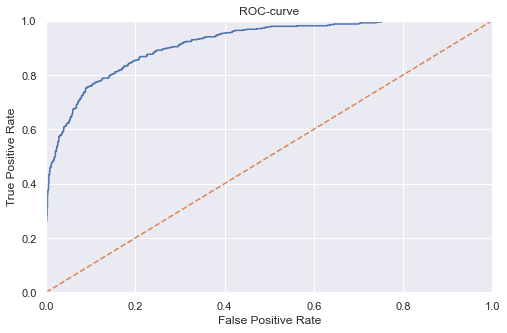

In [72]:
test_scoring(catboost_fitted, features_test, target_test)

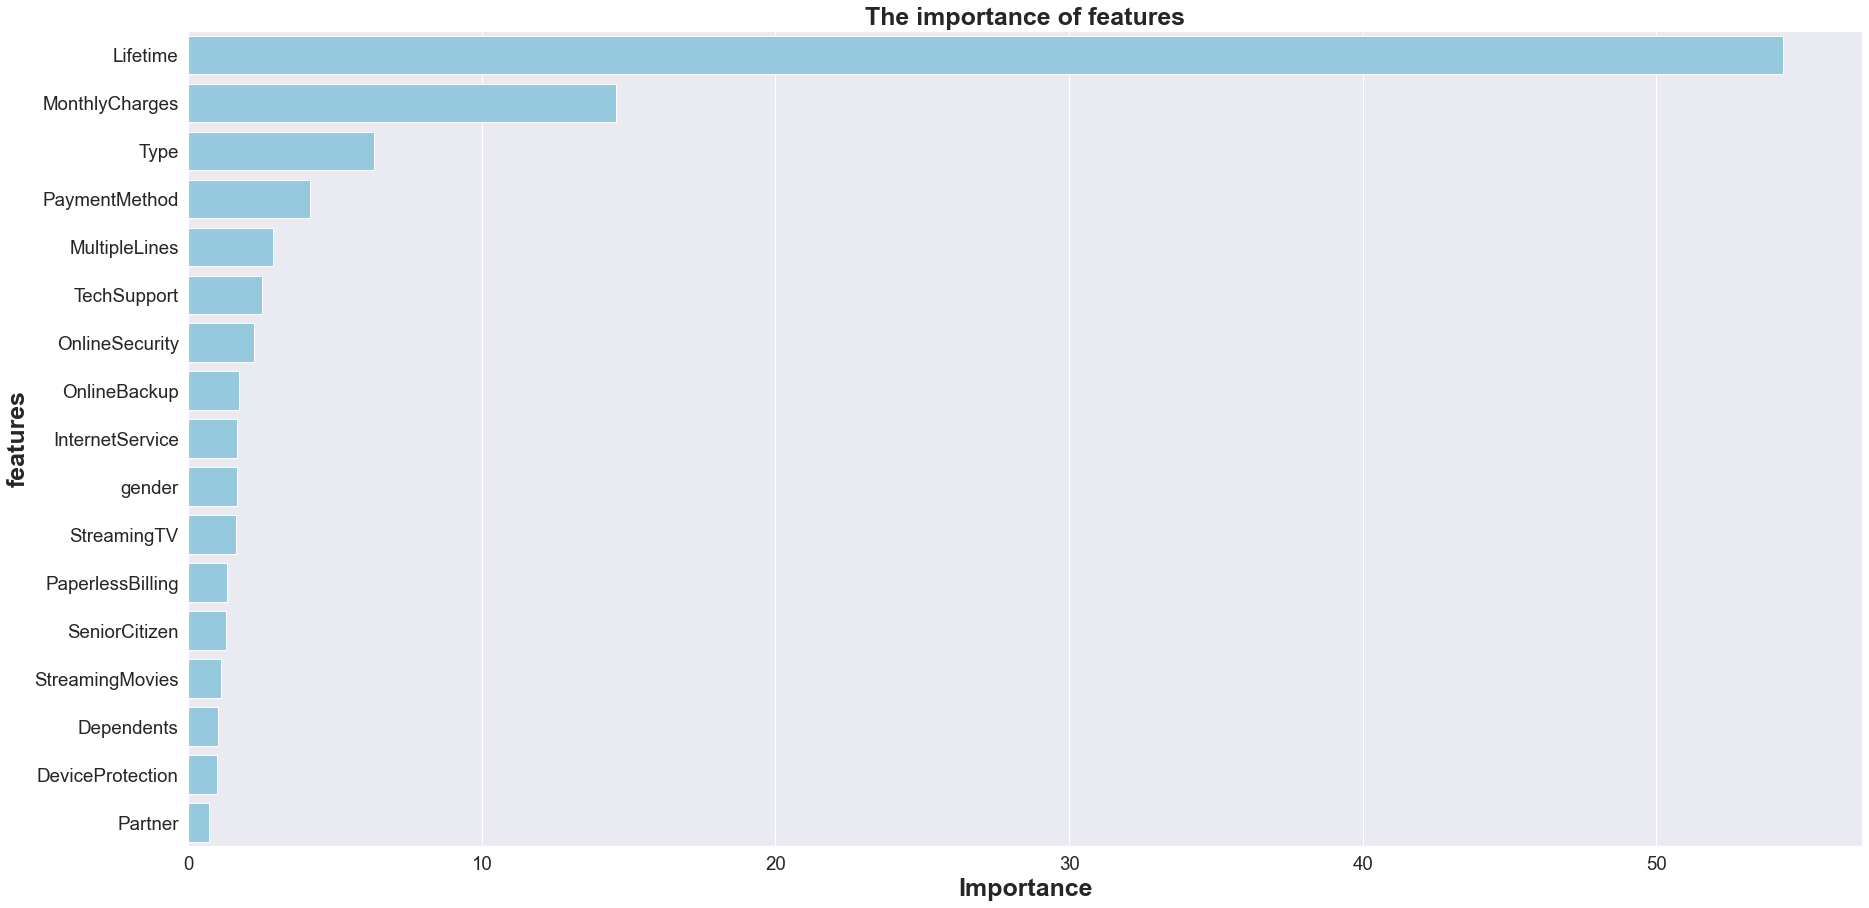

None

,Features,Gini-Importance
0,Lifetime,54.304327
1,MonthlyCharges,14.552922
2,Type,6.334088
3,PaymentMethod,4.141840
4,MultipleLines,2.870313
5,TechSupport,2.497794
6,OnlineSecurity,2.231903
7,OnlineBackup,1.718612
8,InternetService,1.660146
9,gender,1.658015


In [73]:
feature_importance(catboost_fitted, features_train)

Let's remove unimportant features

In [74]:
cat_features_filterred = ['Type',
               'PaymentMethod','MultipleLines','OnlineBackup','InternetService',
               'TechSupport','OnlineSecurity']
features_train_filtered = features_train.drop(['Dependents','Partner','DeviceProtection','StreamingMovies',
                    'SeniorCitizen','StreamingTV','gender','PaperlessBilling'],axis =1 )
features_test_filtered = features_test.drop(['Dependents','Partner','DeviceProtection','StreamingMovies',
                    'SeniorCitizen','StreamingTV','gender','PaperlessBilling'], axis =1)

Test Metrics:
Accuracy:  0.87
Presicion:  0.81
Recall:  0.668
AUC-ROC:  0.921


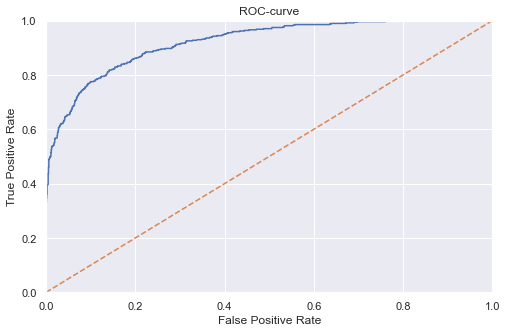

In [75]:
cat_test = CatBoostClassifier(iterations= 200, verbose=0,cat_features=cat_features_filterred, 
                        learning_rate=0.5,depth=5, random_state=666)
cat_test.fit(features_train_filtered, target_train)
test_scoring(cat_test, features_test_filtered, target_test)
# predictions_cat=cat_test.predict(features_test_filtered)
# probabilities_test =cat_test.predict_proba(features_test_filtered)
# probabilities_one_test = probabilities_test[:,1]


### Neural network

In [76]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [77]:
for gpu in gpus:
 tf.config.experimental.set_memory_growth(gpu, True)

In [78]:
optimizer = Adam(lr=0.0001)
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=500, input_dim=features_train_ohe.shape[1],activation='relu'))
model.add(keras.layers.Dense(units=250, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
model.fit(features_train_ohe, target_train_ohe, validation_data =(features_test_ohe, target_test_ohe), verbose=2, epochs=4, batch_size=10)

Epoch 1/4
528/528 - 4s - loss: 0.4547 - acc: 0.7804 - val_loss: 0.4197 - val_acc: 0.7992
Epoch 2/4
528/528 - 2s - loss: 0.4204 - acc: 0.7998 - val_loss: 0.4151 - val_acc: 0.8032
Epoch 3/4
528/528 - 2s - loss: 0.4140 - acc: 0.8036 - val_loss: 0.4144 - val_acc: 0.8003
Epoch 4/4
528/528 - 2s - loss: 0.4103 - acc: 0.8077 - val_loss: 0.4148 - val_acc: 0.8003


Test Metrics:
Accuracy:  0.865
Presicion:  0.785
Recall:  0.679
AUC-ROC:  0.806


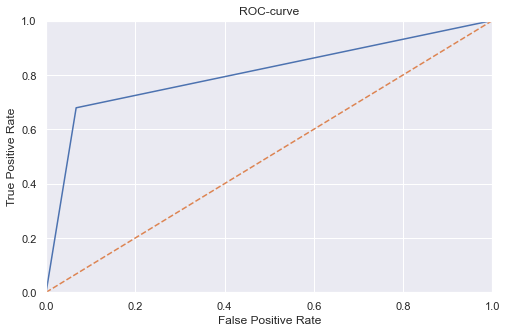

In [79]:

test_scoring(catboost_fitted, features_test, target_test, True)

Well ... not this time

### Dummy model

In [80]:
constant=[[0]]*target_test.shape[0]
roc_auc=roc_auc_score(target_test, constant)
roc_auc

0.5

Any of the models provided above exceeds the dummy model

## Conclusion

The model of gradient busting is best shown - CatBoost with parameters {'depth': 5, 'learning_rate': 0.5} with 200 iterations. **AUC-ROC** on test sample reached **0.921** and **0.905** on training.
The second place was taken by the model LGBMClassifier(l2_leaf_reg=1, max_depth=5, n_estimators=500, random_state=666). It's **AUC-ROC** on test sample reached **0.908** and **0.906** on training.

Both models have shown that they consider it the most influential client's care index *Lifetime* as well as monthly payment, though based on the oconclusion of the data analysis section, you can find different theories.

The goal is achieved. You can recommend a capable model CatBoot {'depth': 5, 'learning_rate': 0.5, iterations:200}, which showed metrics
* Accuracy:  0.87

* Presicion:  0.81

* Recall:  0.668

* AUC-ROC:  0.921

or LGBMClassifier(l2_leaf_reg=1, max_depth=5, n_estimators=500, random_state=666) with almost with identical metrics